In [26]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import math

## Análise das movimentações a partir dos dados do CAGED de 2024

### Criar uma lista com as funções com o maior quantitativo ao longo dos anos

Usamos o histórico porque tinha a indicação da CBO - que será a chave para cruzar com as informações do CAGED

In [27]:
# Lista bruta em formato de string
lista_categorias = """
517330 - VIGILANTE
514320 - FAXINEIRO
422105 - RECEPCIONISTA, EM GERAL
411010 - ASSISTENTE ADMINISTRATIVO
411005 - AUXILIAR DE ESCRITORIO
422310 - OPERADOR DE TELEMARKETING ATIVO E RECEPTIVO
422305 - OPERADOR DE TELEMARKETING ATIVO
517410 - PORTEIRO DE EDIFICIOS
351505 - TECNICO EM SECRETARIADO
517410 - PORTEIRO
513425 - COPEIRO
514320 - AUXILIAR DE LIMPEZA
514325 - TRABALHADOR DA MANUTENCAO DE EDIFICACOES
513425 - COPEIRO
782305 - MOTORISTA DE CARRO DE PASSEIO
252105 - ADMINISTRADOR
514225 - TRABALHADOR DE SERVICOS DE LIMPEZA E CONSERVACAO DE AREAS PUBLICAS
422315 - OPERADOR DE TELEMARKETING RECEPTIVO
622010 - JARDINEIRO
517420 - VIGIA
"""

In [28]:
# Quebra por linha, separa pelo hífen e limpa
linhas = [linha.strip() for linha in lista_categorias.strip().split("\n")]
dados = [linha.split(" - ", 1) for linha in linhas]

In [29]:
# Cria DataFrame
df_categorias = pd.DataFrame(dados, columns=["cbo_2002", "categoria_profissional"])

# Remove duplicatas, se desejar
df_categorias = df_categorias.drop_duplicates()

# Garante que o código CBO seja string
df_categorias["cbo_2002"] = df_categorias["cbo_2002"].astype(str)

In [30]:
df_categorias

,cbo_2002,categoria_profissional
0,517330,VIGILANTE
1,514320,FAXINEIRO
2,422105,"RECEPCIONISTA, EM GERAL"
3,411010,ASSISTENTE ADMINISTRATIVO
4,411005,AUXILIAR DE ESCRITORIO
5,422310,OPERADOR DE TELEMARKETING ATIVO E RECEPTIVO
6,422305,OPERADOR DE TELEMARKETING ATIVO
7,517410,PORTEIRO DE EDIFICIOS
8,351505,TECNICO EM SECRETARIADO
9,517410,PORTEIRO


### Organizar os dados do CAGED para as categorias de interesse

In [31]:
usecols = ["uf", "cbo2002ocupação", "graudeinstrução", "raçacor", "sexo", "salário", "saldomovimentação"]  # e "anomes" ou algo semelhante, se já existir
dtypes = {
    "saldomovimentação": "int8",
    "competênciamov": "str", 
    "uf": "str",
    "graudeinstrução": "int8", 
    "raçacor": "int8", 
    "sexo": "int8", 
    "salário": "str"   
}

In [32]:
# Pasta onde estão os arquivos
pasta = "../data/caged_2024/"

# Lista todos os arquivos txt
arquivos = sorted([os.path.join(pasta, f) for f in os.listdir(pasta) if f.endswith(".txt")])

In [33]:
dfs = []
for arquivo in arquivos:
    df_mes = pd.read_csv(arquivo, sep=";", usecols=usecols, dtype=dtypes, low_memory=False)
    df_mes["ano_mes"] = os.path.basename(arquivo).replace("CAGEDMOV", "").replace(".txt", "")
    dfs.append(df_mes)

In [34]:
df_caged_2024 = pd.concat(dfs, ignore_index=True)

In [35]:
df_caged_2024.columns

Index(['uf', 'saldomovimentação', 'cbo2002ocupação', 'graudeinstrução',
       'raçacor', 'sexo', 'salário', 'ano_mes'],
      dtype='object')

In [36]:
df_caged_2024.head()

,uf,saldomovimentação,cbo2002ocupação,graudeinstrução,raçacor,sexo,salário,ano_mes
0,26,1,411010,7,3,1,"1800,00",202401
1,31,-1,514320,5,2,3,"1394,24",202401
2,35,1,422310,7,3,1,"1324,00",202401
3,32,1,411005,7,3,1,"1450,00",202401
4,33,-1,514225,6,3,1,"1516,00",202401


### Calcular o saldo de movimentação por CBO das categorias de interesse

In [37]:
# Garante que o campo esteja em string
df_caged_2024["cbo2002ocupação"] = df_caged_2024["cbo2002ocupação"].astype(str)

# Filtra pelas categorias que te interessam
df_filtrado = df_caged_2024[df_caged_2024["cbo2002ocupação"].isin(df_categorias["cbo_2002"])]

In [38]:
# Agrupa por CBO e mês
saldo_mensal = (
    df_filtrado
    .groupby(["cbo2002ocupação", "ano_mes"])["saldomovimentação"]
    .sum()
    .reset_index(name="saldo_mensal")
)

In [39]:
# Soma total do ano por CBO
saldo_anual = (
    saldo_mensal
    .groupby("cbo2002ocupação")["saldo_mensal"]
    .sum()
    .reset_index(name="saldo_anual")
)

# Junta com os nomes das categorias
resultado = saldo_anual.merge(df_categorias, left_on="cbo2002ocupação", right_on="cbo_2002", how="left")

# Organiza
resultado = resultado[["cbo2002ocupação", "categoria_profissional", "saldo_anual"]]
resultado = resultado.sort_values("saldo_anual", ascending=False)

In [40]:
resultado

,cbo2002ocupação,categoria_profissional,saldo_anual
10,514320,FAXINEIRO,152003
11,514320,AUXILIAR DE LIMPEZA,152003
2,411005,AUXILIAR DE ESCRITORIO,97344
3,411010,ASSISTENTE ADMINISTRATIVO,78855
4,422105,"RECEPCIONISTA, EM GERAL",51747
13,517330,VIGILANTE,21290
9,514225,TRABALHADOR DE SERVICOS DE LIMPEZA E CONSERVAC...,15638
12,514325,TRABALHADOR DA MANUTENCAO DE EDIFICACOES,14070
15,517410,PORTEIRO,10542
14,517410,PORTEIRO DE EDIFICIOS,10542


#### Como há valores díspares, vamos agrupar as categorias em 4 grupos de saldo

In [41]:
# Define grupos por faixas de saldo
def classificar_grupo(saldo):
    if saldo > 100000:
        return "Grupo 1 – Saldo altíssimo (>100 mil)"
    elif saldo > 10000:
        return "Grupo 2 – Saldo alto (10k – 100k)"
    elif saldo > 1000:
        return "Grupo 3 – Saldo médio (1k – 10k)"
    else:
        return "Grupo 4 – Saldo baixo ou negativo (≤1k)"

resultado["faixa_saldo"] = resultado["saldo_anual"].apply(classificar_grupo)

In [42]:
resultado

,cbo2002ocupação,categoria_profissional,saldo_anual,faixa_saldo
10,514320,FAXINEIRO,152003,Grupo 1 – Saldo altíssimo (>100 mil)
11,514320,AUXILIAR DE LIMPEZA,152003,Grupo 1 – Saldo altíssimo (>100 mil)
2,411005,AUXILIAR DE ESCRITORIO,97344,Grupo 2 – Saldo alto (10k – 100k)
3,411010,ASSISTENTE ADMINISTRATIVO,78855,Grupo 2 – Saldo alto (10k – 100k)
4,422105,"RECEPCIONISTA, EM GERAL",51747,Grupo 2 – Saldo alto (10k – 100k)
13,517330,VIGILANTE,21290,Grupo 2 – Saldo alto (10k – 100k)
9,514225,TRABALHADOR DE SERVICOS DE LIMPEZA E CONSERVAC...,15638,Grupo 2 – Saldo alto (10k – 100k)
12,514325,TRABALHADOR DA MANUTENCAO DE EDIFICACOES,14070,Grupo 2 – Saldo alto (10k – 100k)
15,517410,PORTEIRO,10542,Grupo 2 – Saldo alto (10k – 100k)
14,517410,PORTEIRO DE EDIFICIOS,10542,Grupo 2 – Saldo alto (10k – 100k)


### Saldo de movimentações no ano de 2024

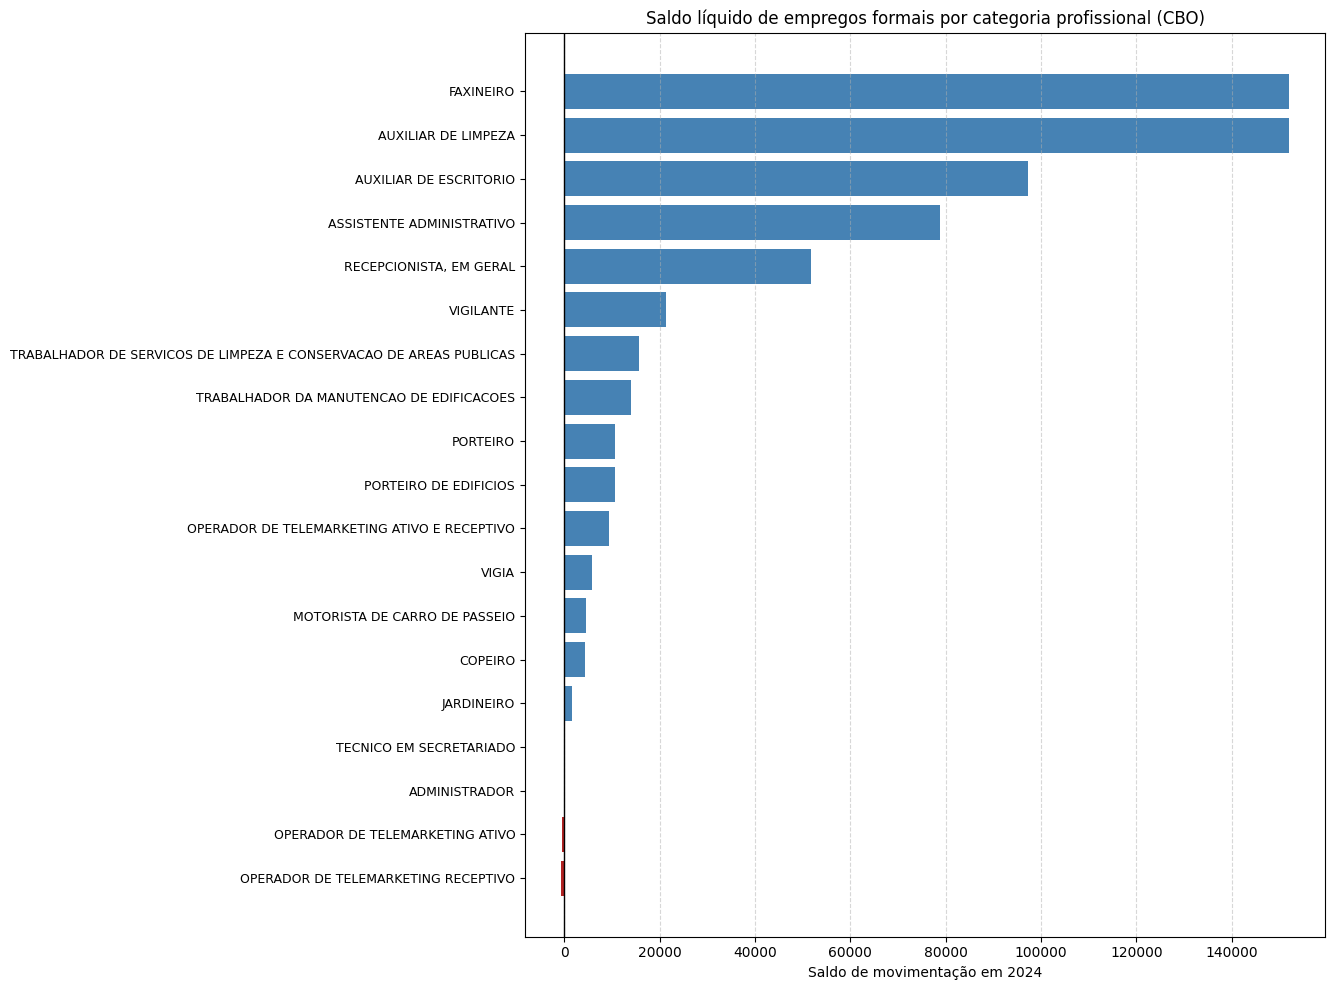

In [43]:
# Ordena do menor para o maior saldo
resultado_plot = resultado.sort_values("saldo_anual", ascending=True)

# Define cores: uma para saldo positivo, outra para negativo
cores = resultado_plot["saldo_anual"].apply(lambda x: "firebrick" if x < 0 else "steelblue")

# Cria gráfico com maior largura e mais clareza
plt.figure(figsize=(14, 10))  # Aumenta a largura (14)
plt.barh(resultado_plot["categoria_profissional"], resultado_plot["saldo_anual"], color=cores)

# Linha vertical no zero para referência
plt.axvline(x=0, color="black", linewidth=1)

# Rótulos
plt.xlabel("Saldo de movimentação em 2024")
plt.title("Saldo líquido de empregos formais por categoria profissional (CBO)")

# Grade leve
plt.grid(axis="x", linestyle="--", alpha=0.5)

# Ajustes visuais
plt.tight_layout()
plt.xticks(fontsize=10)
plt.yticks(fontsize=9)

# Caminho e nome do arquivo
#plt.savefig("./graficos/saldo_2024.png", dpi=300)  # Salva em alta resolução

# Mostra gráfico
plt.show()

### Verificar a relação de quantas mulheres configuram o saldo de movimentações

In [44]:
df_caged_2024['sexo'].value_counts()

1    28494836
3    20500968
9         236
Name: sexo, dtype: int64

In [45]:
# Agrupa saldo por CBO e sexo
saldo_por_sexo = (
    df_filtrado
    .groupby(["cbo2002ocupação", "sexo"])["saldomovimentação"]
    .sum()
    .reset_index(name="saldo")
)

In [46]:
mapa_sexo = {1: "Homem", 3: "Mulher", 9: "Não identificado"}
saldo_por_sexo["sexo_label"] = saldo_por_sexo["sexo"].map(mapa_sexo)

In [47]:
# Junta com o dataframe consolidado de categorias
saldo_por_sexo = saldo_por_sexo.merge(
    resultado[["cbo2002ocupação", "categoria_profissional", "faixa_saldo"]],
    on="cbo2002ocupação",
    how="left"
)

In [48]:
saldo_por_sexo["saldo"] = pd.to_numeric(saldo_por_sexo["saldo"], errors="coerce")

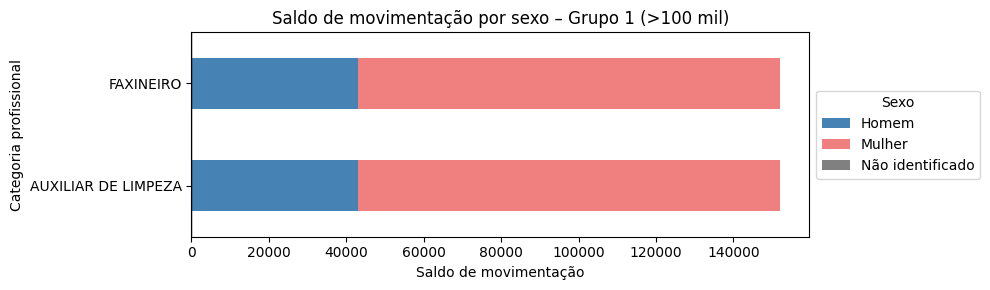

In [49]:
# Filtra só o grupo 1
grupo1 = saldo_por_sexo[saldo_por_sexo["faixa_saldo"] == "Grupo 1 – Saldo altíssimo (>100 mil)"]

# Cria pivot
pivot_grupo1 = grupo1.pivot_table(
    index="categoria_profissional",
    columns="sexo_label",
    values="saldo",
    aggfunc="sum",
    fill_value=0
)

# Ordena por saldo total
pivot_grupo1 = pivot_grupo1.loc[pivot_grupo1.sum(axis=1).sort_values().index]
pivot_grupo1 = pivot_grupo1.select_dtypes(include=["number"])

# Cores padronizadas
cores_sexo = {
    "Homem": "steelblue",
    "Mulher": "lightcoral",
    "Não identificado": "gray"
}
cores_usadas = [cores_sexo.get(col, "gray") for col in pivot_grupo1.columns]

# Plot específico para Grupo 1 (mais compacto)
ax = pivot_grupo1.plot(
    kind="barh",
    stacked=True,
    figsize=(10, 3),  # largura ok, altura reduzida
    color=cores_usadas
)

plt.axvline(x=0, color="black", linewidth=1)
plt.title("Saldo de movimentação por sexo – Grupo 1 (>100 mil)")
plt.xlabel("Saldo de movimentação")
plt.ylabel("Categoria profissional")
plt.legend(title="Sexo", loc="center left", bbox_to_anchor=(1.0, 0.5))
plt.tight_layout()

# Caminho e nome do arquivo
#plt.savefig("./graficos/saldo_genero_1.png", dpi=300)  # Salva em alta resolução

plt.show()

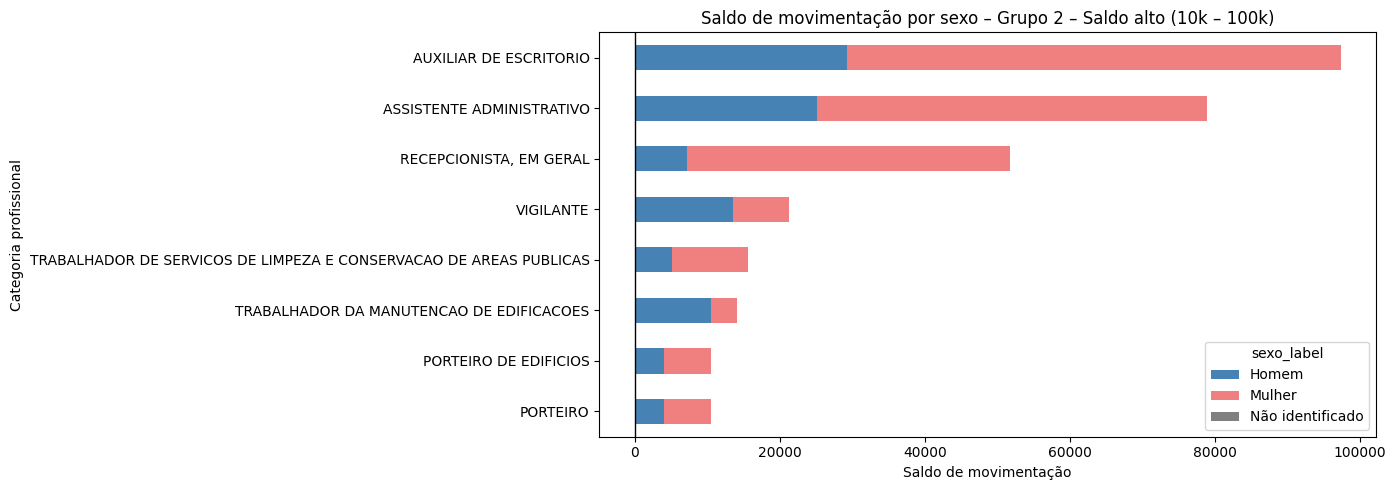

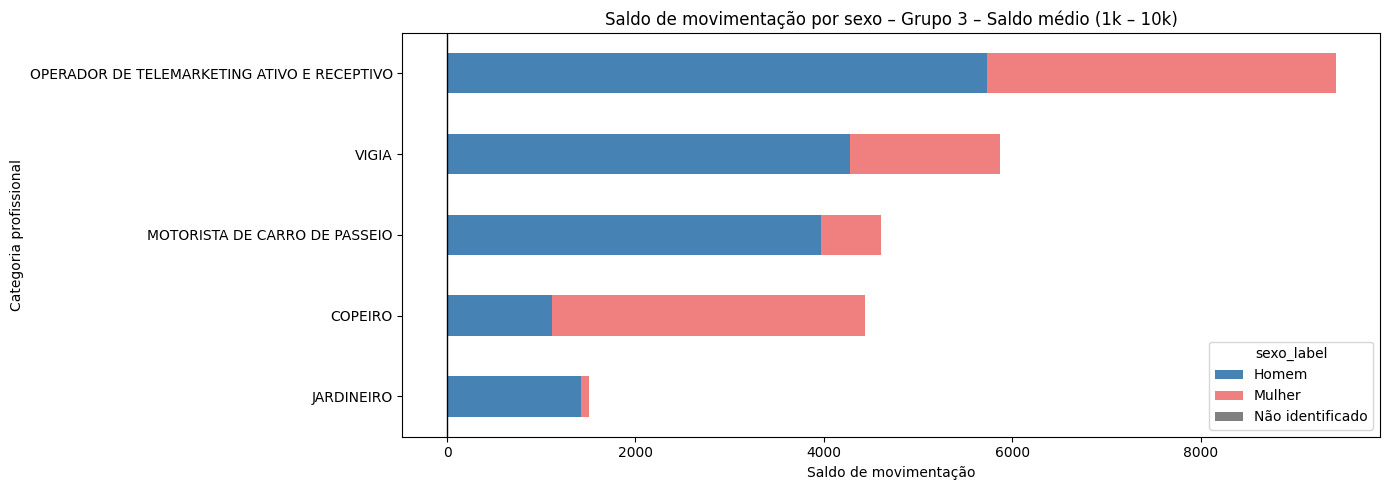

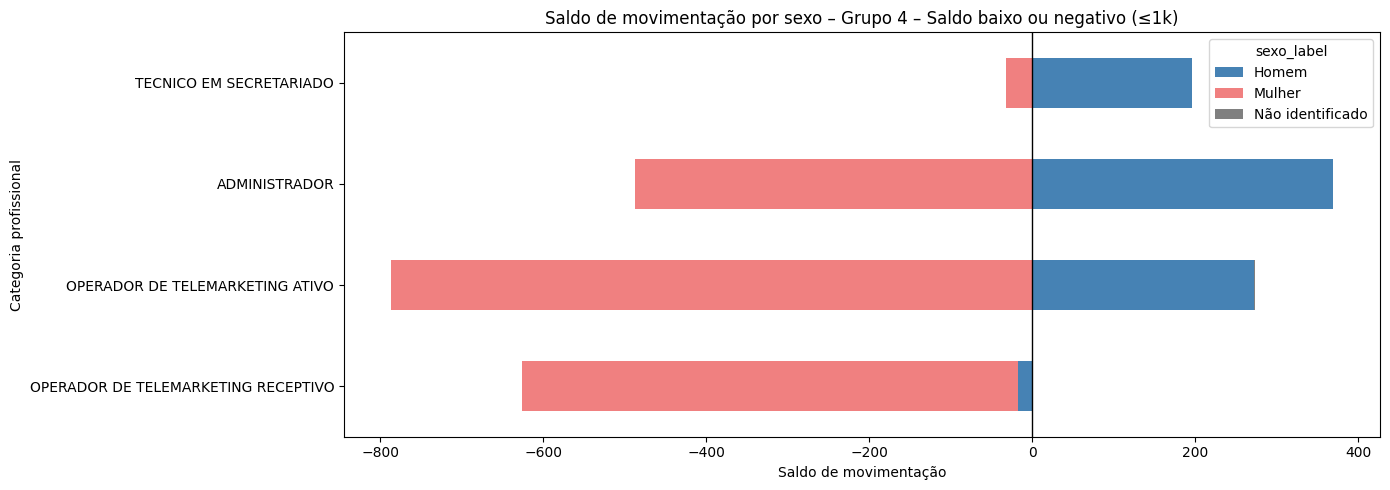

In [50]:
# Grupos restantes (exclui o Grupo 1)
grupos_restantes = saldo_por_sexo[saldo_por_sexo["faixa_saldo"] != "Grupo 1 – Saldo altíssimo (>100 mil)"]

# Cores padronizadas
cores_sexo = {
    "Homem": "steelblue",
    "Mulher": "lightcoral",
    "Não identificado": "gray"
}

# Loop por grupo
for grupo, dados in grupos_restantes.groupby("faixa_saldo"):

    pivot_grupo = dados.pivot_table(
        index="categoria_profissional",
        columns="sexo_label",
        values="saldo",
        aggfunc="sum",
        fill_value=0
    )

    pivot_grupo = pivot_grupo.loc[pivot_grupo.sum(axis=1).sort_values().index]
    pivot_grupo = pivot_grupo.select_dtypes(include=["number"])

    cores_usadas = [cores_sexo.get(col, "gray") for col in pivot_grupo.columns]

    # Altura ajustada dinamicamente (0.5 por categoria, mínimo de 5)
    altura = max(5, len(pivot_grupo) * 0.6)

    # Plot
    ax = pivot_grupo.plot(
        kind="barh",
        stacked=True,
        figsize=(14, altura),
        color=cores_usadas
    )

    plt.axvline(x=0, color="black", linewidth=1)
    plt.title(f"Saldo de movimentação por sexo – {grupo}")
    plt.xlabel("Saldo de movimentação")
    plt.ylabel("Categoria profissional")
    plt.tight_layout()
    # Caminho e nome do arquivo
    #plt.savefig(f"./graficos/saldo_genero_{grupo}.png", dpi=300)  # Salva em alta resolução
    plt.show()

### Verificar raça e cor no saldo de movimentações

In [51]:
# Agrupa corretamente por função (CBO) e raça/cor
saldo_por_raca = (
    df_filtrado
    .groupby(["cbo2002ocupação", "raçacor"], as_index=False)["saldomovimentação"]
    .sum()
    .rename(columns={"saldomovimentação": "saldo"})
)

In [52]:
mapa_raca = {
    1: "Branca",
    2: "Preta",
    3: "Parda",
    4: "Amarela",
    5: "Indígena",
    6: "Não informada",
}

saldo_por_raca["raca_label"] = saldo_por_raca["raçacor"].map(mapa_raca)

In [53]:
saldo_por_raca = saldo_por_raca.merge(
    resultado[["cbo2002ocupação", "categoria_profissional", "faixa_saldo"]],
    on="cbo2002ocupação",
    how="left"
)

In [54]:
saldo_por_raca["saldo"] = pd.to_numeric(saldo_por_raca["saldo"], errors="coerce")

In [55]:
# Garante que a pasta exista
os.makedirs("./graficos", exist_ok=True)

In [56]:
# Paleta de cores padrão
cores_raca = {
    "Branca": "#9ecae1",
    "Preta": "#6a51a3",
    "Parda": "#a1d99b",
    "Amarela": "#ffcc00",
    "Indígena": "#d95f0e",
    "Não informada": "#cccccc"
}

In [57]:
# Lista de grupos na ordem
grupos_ordenados = [
    "Grupo 1 – Saldo altíssimo (>100 mil)",
    "Grupo 2 – Saldo alto (10k – 100k)",
    "Grupo 3 – Saldo médio (1k – 10k)",
    "Grupo 4 – Saldo baixo ou negativo (≤1k)"
]

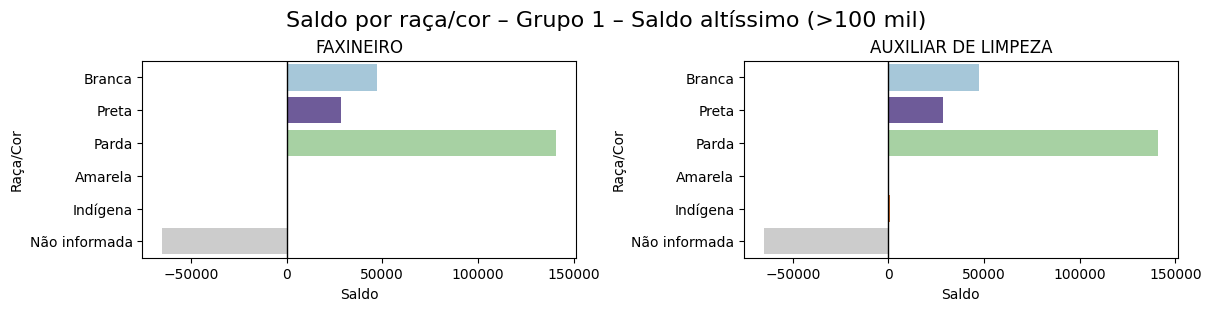

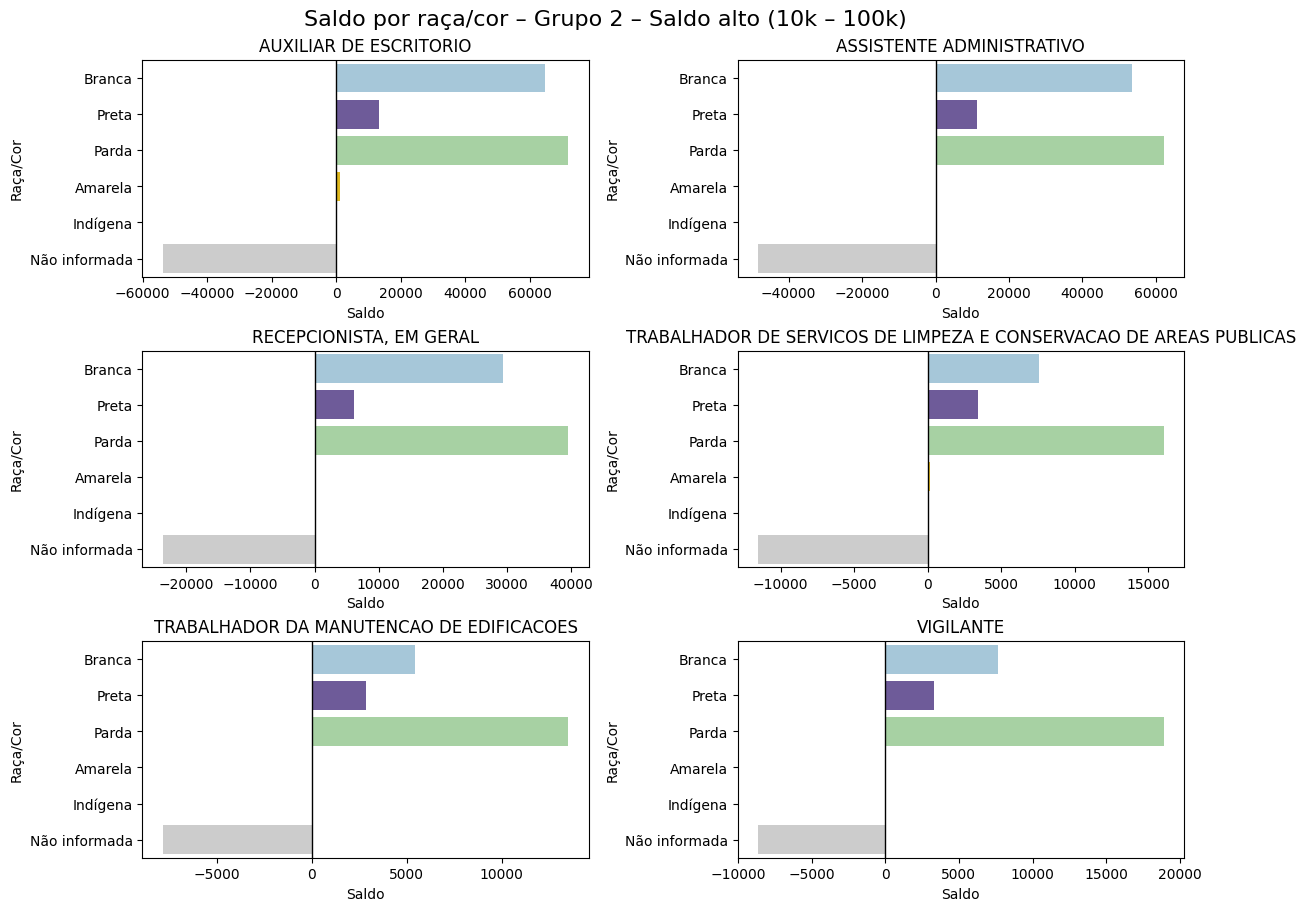

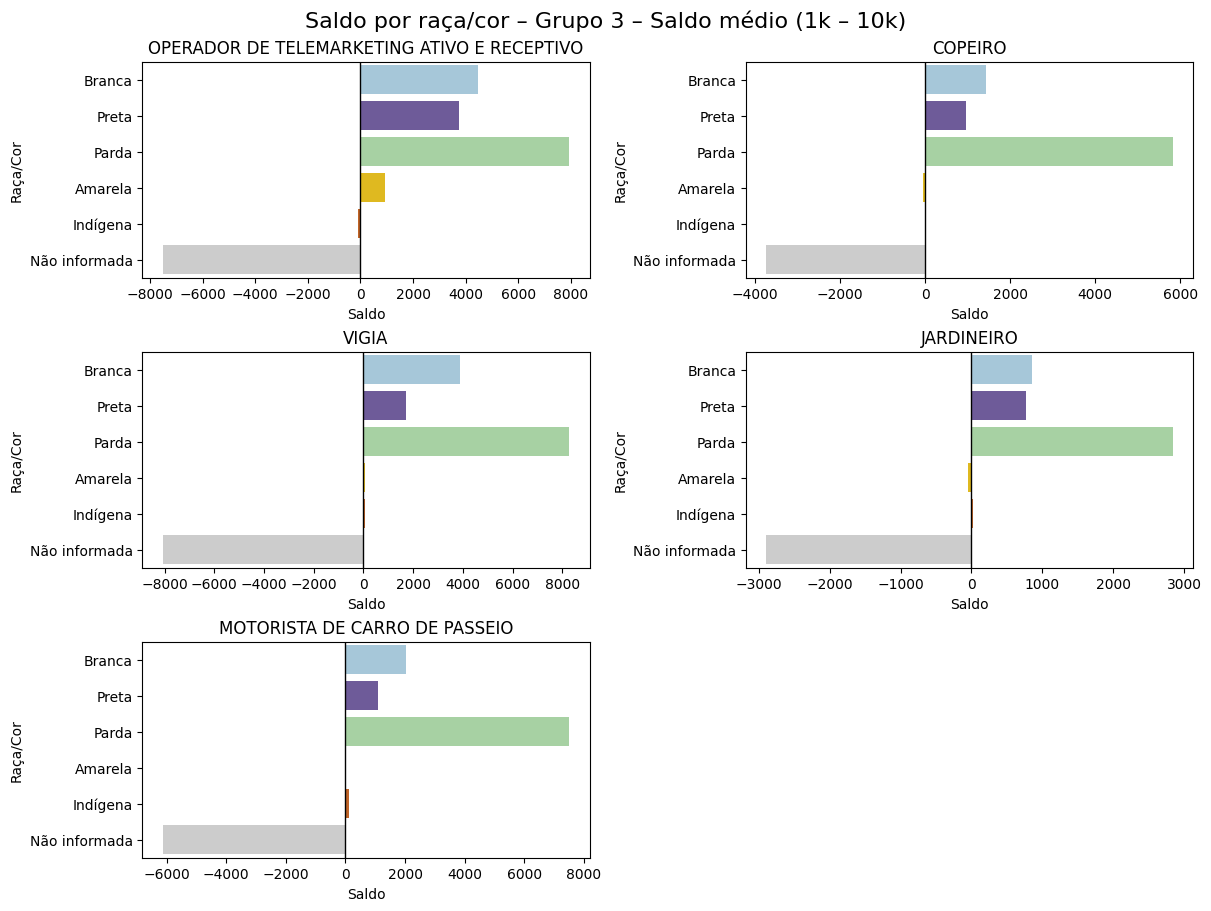

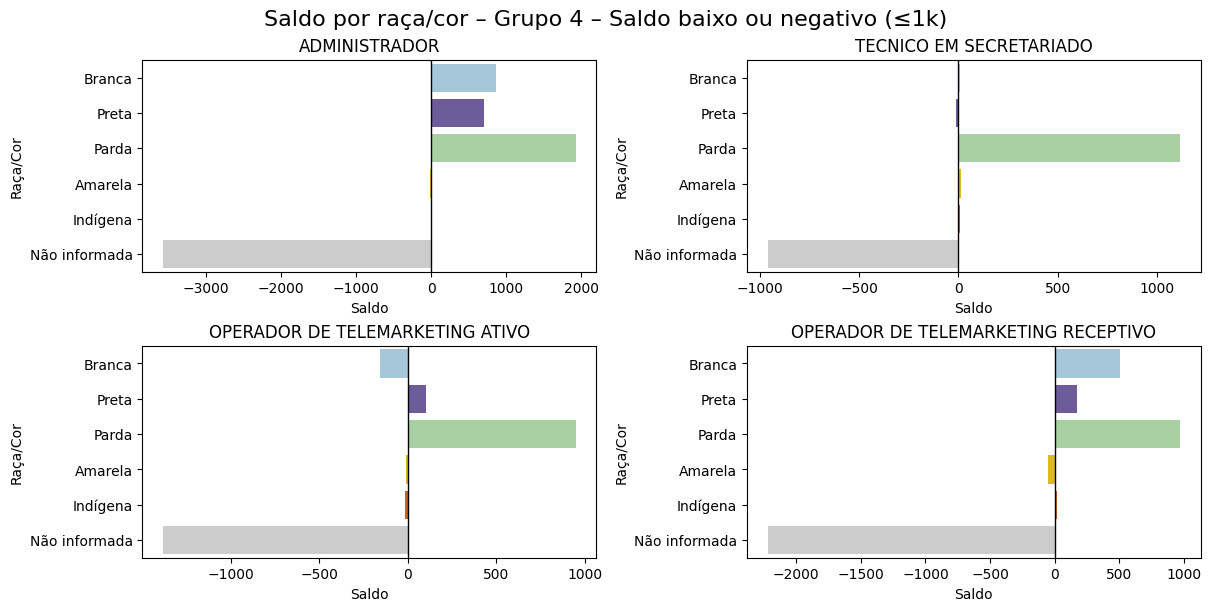

In [58]:
# Número de funções por gráfico (ajustável)
top_n = 6

for i, grupo_alvo in enumerate(grupos_ordenados, start=1):
    dados_grupo = saldo_por_raca[saldo_por_raca["faixa_saldo"] == grupo_alvo]

    # Seleciona funções mais impactantes por saldo absoluto
    categorias_chave = (
        dados_grupo.groupby("categoria_profissional")["saldo"]
        .sum()
        .abs()
        .sort_values(ascending=False)
        .head(top_n)
        .index.tolist()
    )

    dados_foco = dados_grupo[dados_grupo["categoria_profissional"].isin(categorias_chave)]

    categorias_unicas = dados_foco["categoria_profissional"].unique()
    n = len(categorias_unicas)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 3), constrained_layout=True)
    axes = axes.flatten()

    for j, categoria in enumerate(categorias_unicas):
        ax = axes[j]
        dados_cbo = dados_foco[dados_foco["categoria_profissional"] == categoria]
        sns.barplot(
            data=dados_cbo,
            x="saldo",
            y="raca_label",
            hue="raca_label",
            palette=cores_raca,
            ax=ax,
            orient="h",
            legend=False
        )
        ax.axvline(x=0, color="black", linewidth=1)
        ax.set_title(categoria)
        ax.set_xlabel("Saldo")
        ax.set_ylabel("Raça/Cor")

    # Remove subplots vazios
    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    fig.suptitle(f"Saldo por raça/cor – {grupo_alvo}", fontsize=16)
    #plt.savefig(f"./graficos/saldo_raca_grupo{i}.png", dpi=300)
    plt.show()

### Identificar relação entre mulheres e raça/cor

In [59]:
# Filtrar mulheres
df_mulheres = df_filtrado[df_filtrado["sexo"] == 3]

In [60]:
# Calcular saldo anual por CBO
saldo_mulheres = (
    df_mulheres
    .groupby("cbo2002ocupação")["saldomovimentação"]
    .sum()
    .reset_index(name="saldo_anual")
)

In [61]:
# Trazer categoria e faixa do resultado (base geral)
df_faixas_referencia = resultado.rename(columns={
    "categoria_profissional": "categoria"
})[["cbo2002ocupação", "categoria", "faixa_saldo"]]

saldo_mulheres = saldo_mulheres.merge(df_faixas_referencia, on="cbo2002ocupação", how="left")

In [62]:
# Calcular saldo por raça
saldo_mulheres_raca = (
    df_mulheres
    .groupby(["cbo2002ocupação", "raçacor"])["saldomovimentação"]
    .sum()
    .reset_index(name="saldo")
)

In [63]:
saldo_mulheres_raca["raca_label"] = saldo_mulheres_raca["raçacor"].map(mapa_raca)
saldo_mulheres_raca = saldo_mulheres_raca[saldo_mulheres_raca["raçacor"] != 9]

In [64]:
saldo_mulheres_raca = saldo_mulheres_raca.merge(
    saldo_mulheres[["cbo2002ocupação", "categoria", "faixa_saldo"]],
    on="cbo2002ocupação",
    how="left"
)

In [66]:
categorias_top_por_grupo = {}

for grupo in grupos_ordenados:
    dados_grupo = saldo_por_raca[saldo_por_raca["faixa_saldo"] == grupo]

    top_funcoes = (
        dados_grupo.groupby("categoria_profissional")["saldo"]
        .sum()
        .abs()
        .sort_values(ascending=False)
        .head(6)
        .index.tolist()
    )

    categorias_top_por_grupo[grupo] = top_funcoes

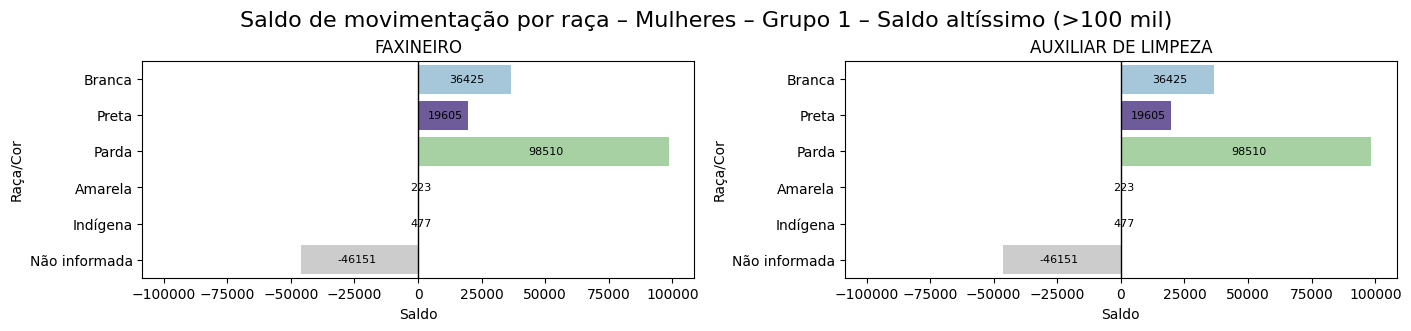

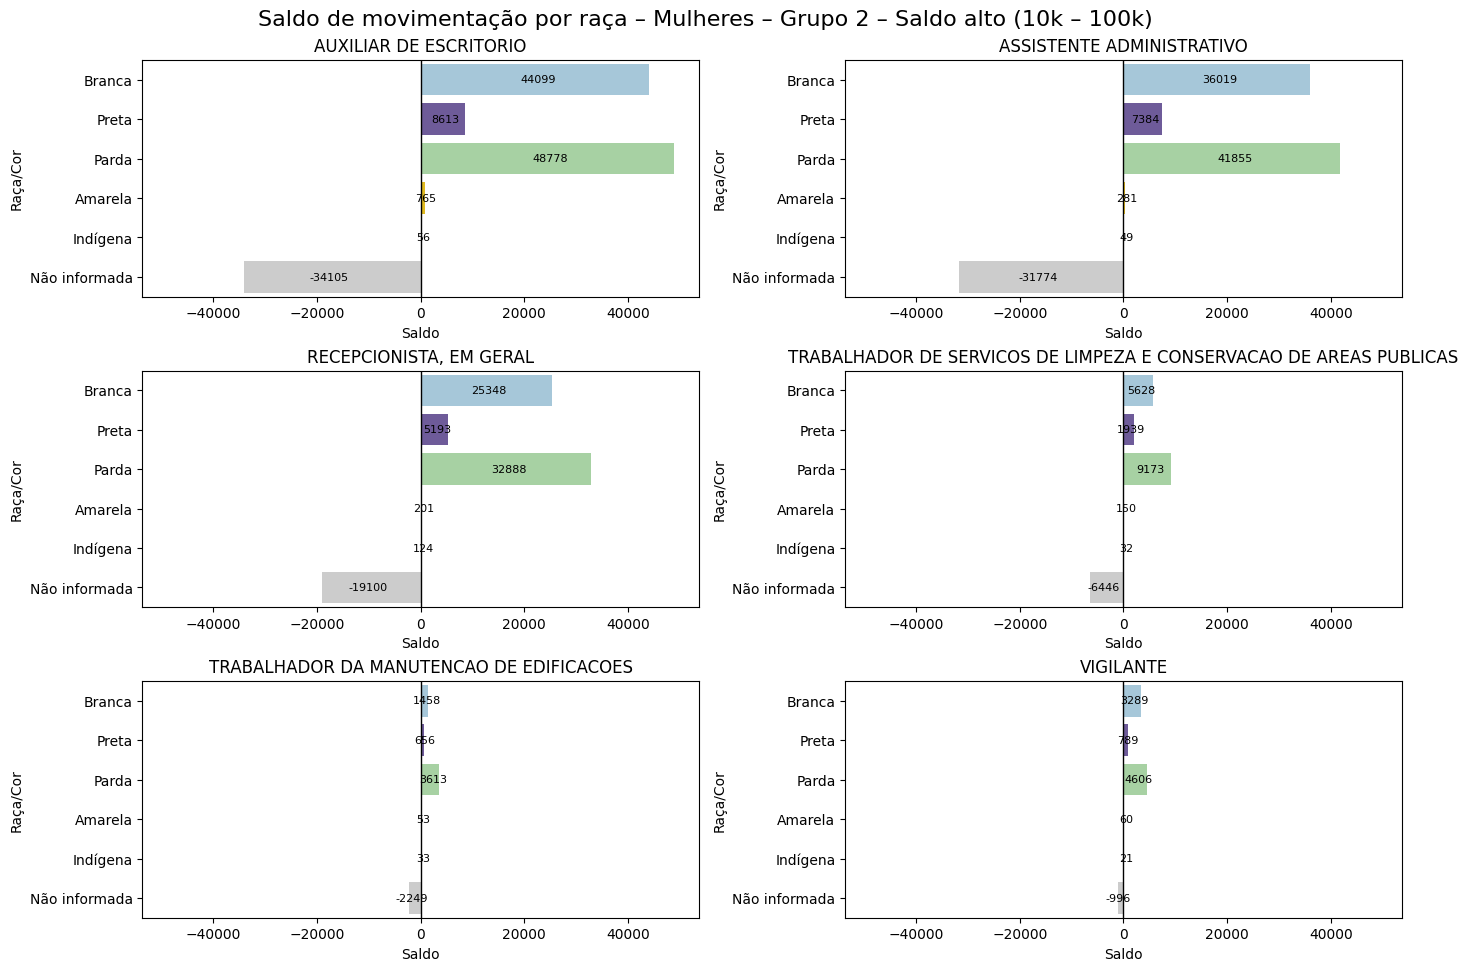

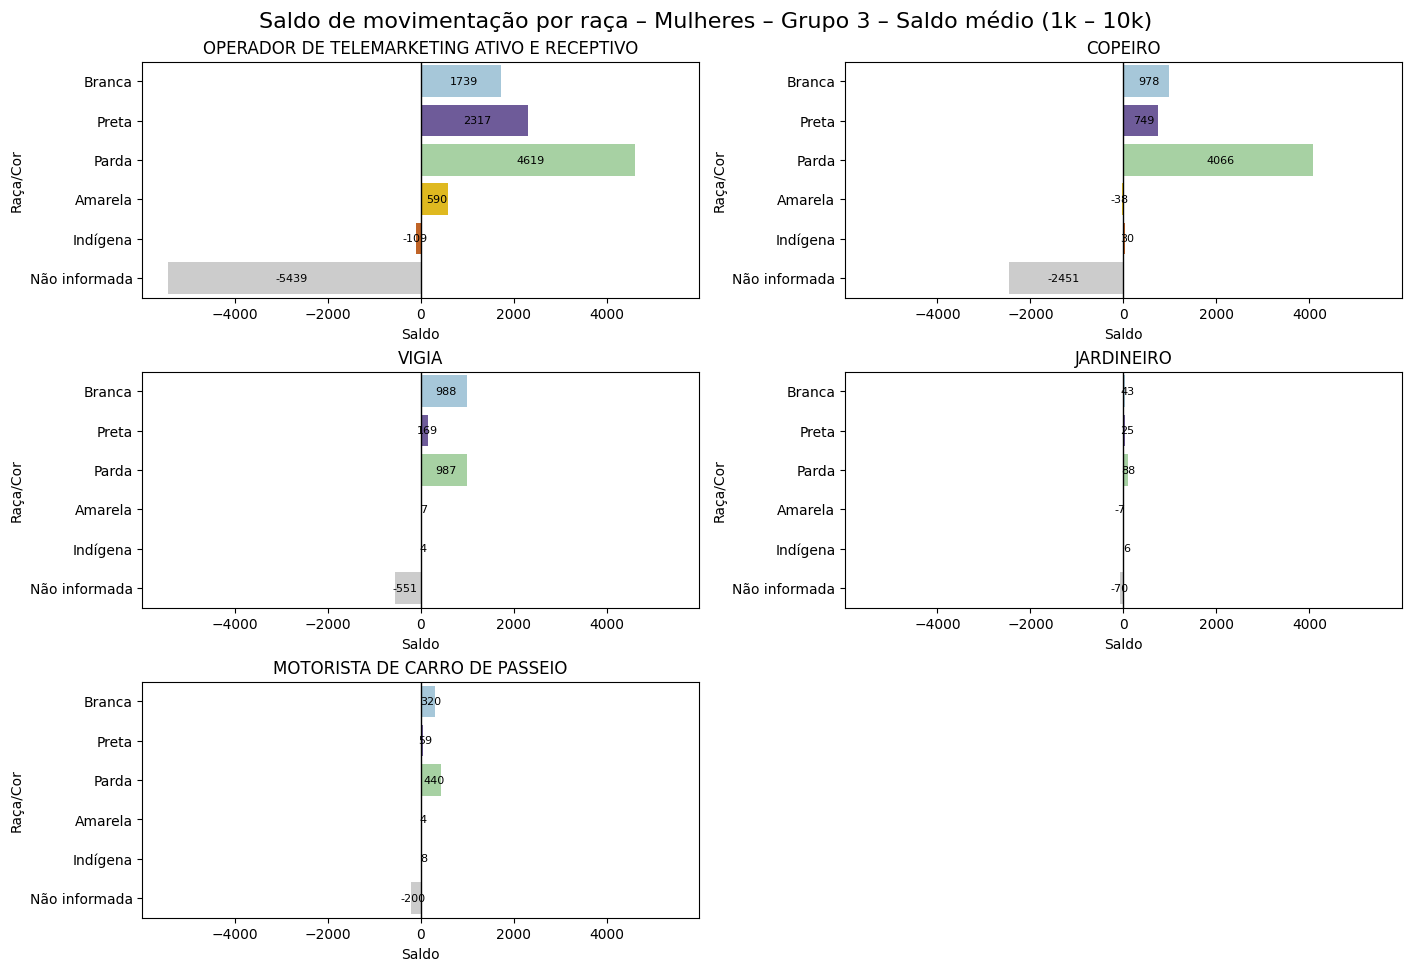

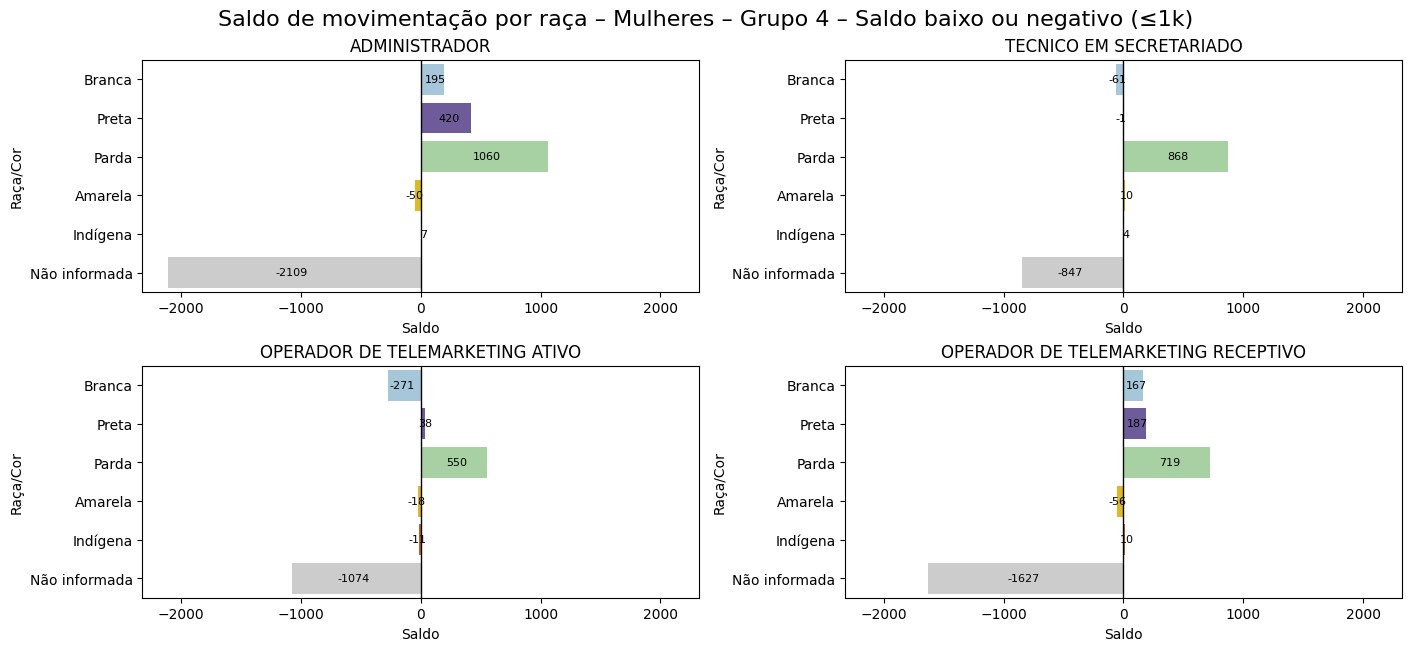

In [67]:
# Gráficos por grupo
for i, grupo_alvo in enumerate(grupos_ordenados, start=1):
    dados_grupo = saldo_mulheres_raca[saldo_mulheres_raca["faixa_saldo"] == grupo_alvo]
    categorias_chave = categorias_top_por_grupo.get(grupo_alvo, [])
    dados_foco = dados_grupo[dados_grupo["categoria"].isin(categorias_chave)]

    categorias_unicas = dados_foco["categoria"].unique()
    n = len(categorias_unicas)
    ncols = 2
    nrows = math.ceil(n / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(14, nrows * 3.2), constrained_layout=True)
    axes = axes.flatten()

    x_min = dados_foco["saldo"].min()
    x_max = dados_foco["saldo"].max()
    x_padrao = max(abs(x_min), abs(x_max))
    x_limite = (-x_padrao * 1.1, x_padrao * 1.1)

    for j, categoria in enumerate(categorias_unicas):
        ax = axes[j]
        dados_cbo = dados_foco[dados_foco["categoria"] == categoria]

        sns.barplot(
            data=dados_cbo,
            x="saldo",
            y="raca_label",
            hue="raca_label",
            palette=cores_raca,
            ax=ax,
            orient="h",
            legend=False
        )
        ax.axvline(x=0, color="black", linewidth=1)
        ax.set_xlim(x_limite)
        ax.set_title(categoria)
        ax.set_xlabel("Saldo")
        ax.set_ylabel("Raça/Cor")

        for container in ax.containers:
            ax.bar_label(container, fmt="%.0f", label_type="center", padding=2, fontsize=8)

    for k in range(j + 1, len(axes)):
        fig.delaxes(axes[k])

    fig.suptitle(f"Saldo de movimentação por raça – Mulheres – {grupo_alvo}", fontsize=16)
    #plt.savefig(f"./graficos/saldo_mulheres_raca_grupo{i}.png", dpi=300)
    plt.show()